In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

In [2]:
def build_toy_dataset(N=50, noise_std=0.1):
    x = np.linspace(-6, 6, num=N)
    y = np.cos(x) + np.random.normal(0, noise_std, size=N)
    x = x.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return x, y


def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

In [3]:
N = 50 
D = 1  

x_train, y_train = build_toy_dataset(N)

In [4]:
W_0 = Normal(loc=tf.zeros([D, 4]), scale=tf.ones([D, 4]))
W_1 = Normal(loc=tf.zeros([4, 1]), scale=tf.ones([4, 1]))
b_0 = Normal(loc=tf.zeros(4), scale=tf.ones(4))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1),
           scale=0.1 * tf.ones(N))

In [5]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, 4]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, 4])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [4, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [4, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [4]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [4])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [6]:
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(10)])

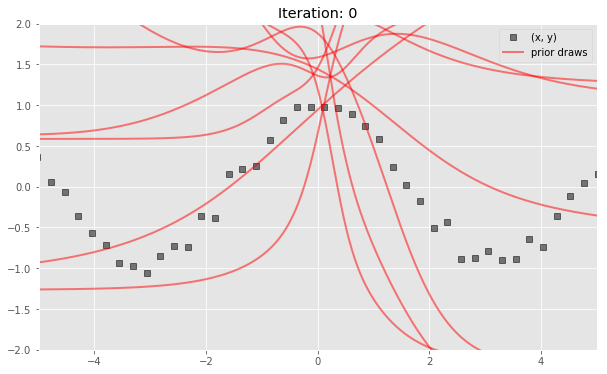

In [7]:
sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

In [8]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=1000, n_samples=5)

/home/app-user/.pyenv/versions/3.6.3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 39.926


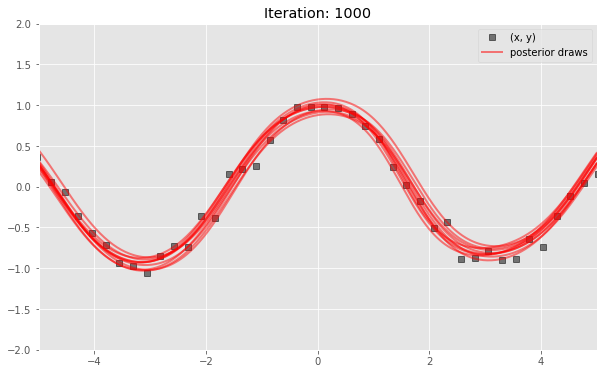

In [9]:
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

In [10]:
y_post = ed.copy(y, {W_0: qW_0, W_1: qW_1, b_0: qb_0, b_1: qb_1})

In [11]:
input_sample = np.reshape(np.linspace(-6, 6, num=400), (400, 1))
y_samples = y_post.sample(1).eval(feed_dict={x: input_sample})

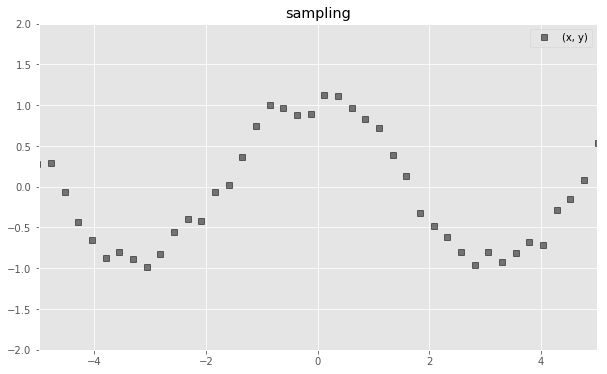

In [12]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("sampling")
ax.plot(np.linspace(-6, 6, num=50), np.reshape(y_samples, (50, )), 'ks', alpha=0.5, label='(x, y)')
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()